Este proyecto se enfoca en el desarrollo de una red neuronal para la clasificación de imágenes utilizando el dataset CIFAR-100. El objetivo principal es crear un modelo capaz de predecir correctamente el contenido de las imágenes, identificando a cuál de las 100 clases pertenece cada imagen.

CIFAR-100 es un conjunto de datos ampliamente utilizado en el campo del aprendizaje profundo que contiene 60,000 imágenes a color de 32x32 píxeles, divididas en 100 clases diferentes. Cada clase representa un objeto o concepto distinto, lo que hace que este dataset sea ideal para tareas de clasificación multiclase.

En este proyecto, implementaremos una red neuronal multicapa utilizando PyTorch, exploraremos diferentes arquitecturas y configuraciones de hiperparámetros, y evaluaremos el rendimiento del modelo utilizando métricas estándar como precisión, recall y F1-score.

## Objetivos del Proyecto
1. Cargar y preprocesar el dataset CIFAR-100
2. Visualizar y analizar las características del conjunto de datos
3. Diseñar e implementar una red neuronal multicapa para clasificación
4. Entrenar el modelo con diferentes configuraciones de hiperparámetros
5. Evaluar el rendimiento del modelo utilizando métricas apropiadas
6. Experimentar con diferentes funciones de activación, tasas de dropout y técnicas de normalización
7. Analizar los resultados y extraer conclusiones

En esta sección importamos todas las bibliotecas necesarias para el proyecto y configuramos parámetros para garantizar la reproducibilidad de los resultados.

In [35]:
# Configuración para reproducibilidad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.datasets as datasets


np.random.seed(42)
torch.manual_seed(42)



##Carga del Dataset CIFAR-100

En esta sección cargamos el dataset CIFAR-100 utilizando PyTorch, exploramos su estructura y visualizamos algunas imágenes de ejemplo para comprender mejor los datos con los que trabajaremos.

In [36]:
# Cargar el dataset CIFAR-100
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

# Extraer datos y etiquetas
X_train = np.array([np.array(x) for x, _ in trainset])
y_train = np.array([y for _, y in trainset]).reshape(-1, 1)
X_test = np.array([np.array(x) for x, _ in testset])
y_test = np.array([y for _, y in testset]).reshape(-1, 1)

print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de las etiquetas de entrenamiento:", y_train.shape)
print("Forma de los datos de prueba:", X_test.shape)
print("Forma de las etiquetas de prueba:", y_test.shape)

Forma de los datos de entrenamiento: (50000, 32, 32, 3)
Forma de las etiquetas de entrenamiento: (50000, 1)
Forma de los datos de prueba: (10000, 32, 32, 3)
Forma de las etiquetas de prueba: (10000, 1)


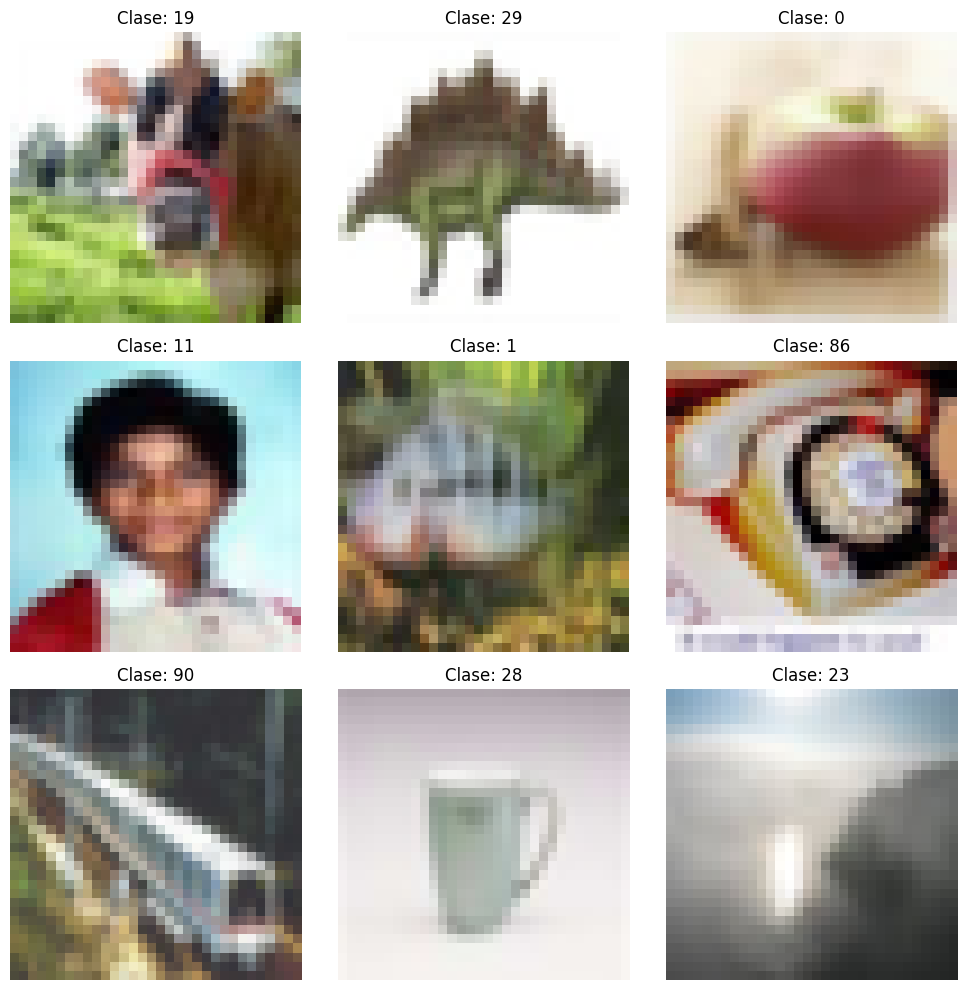

In [37]:
# Visualizar algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Clase: {y_train[i][0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_1968\580960327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train.flatten(), palette='viridis')


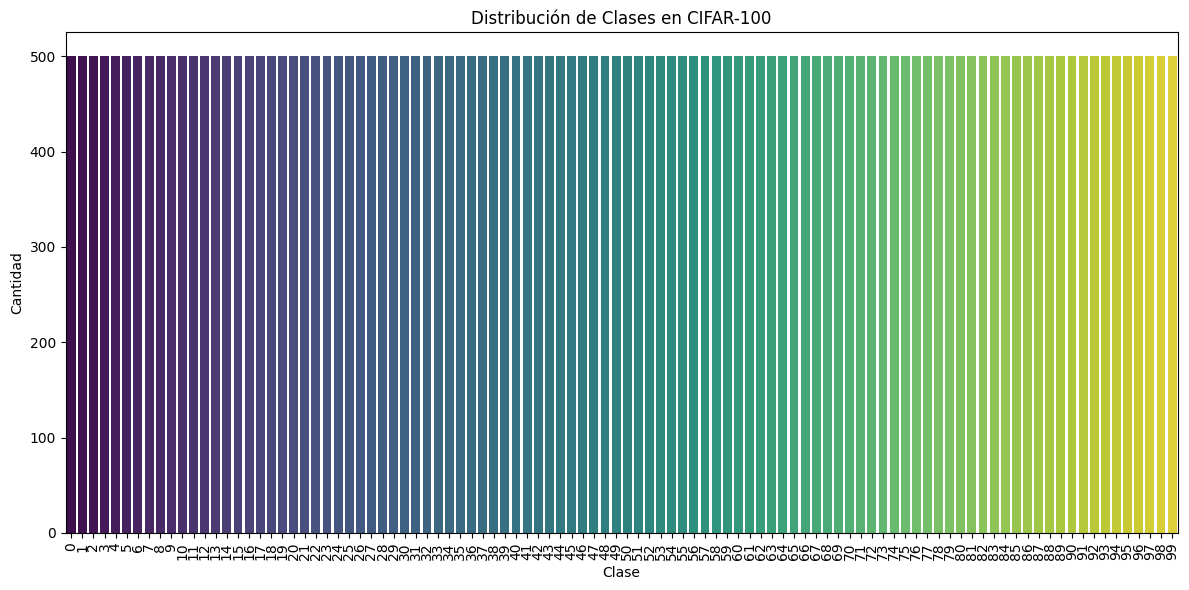

In [38]:
# Análisis de la distribución de clases
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train.flatten(), palette='viridis')
plt.title('Distribución de Clases en CIFAR-100')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Preprocesamiento de Datos
En esta sección realizamos el preprocesamiento necesario de las imágenes, incluyendo normalización y transformación de los datos para que sean compatibles con nuestro modelo de red neuronal.

In [39]:
# Preprocesamiento de datos
# Normalización manual de los datos de imagen (dividiendo por 255)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


# Las imágenes son de 32x32x3, las convertimos a vectores de 32*32*3 = 3072 elementos
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print("Forma de los datos reshapeados de entrenamiento:", X_train_reshaped.shape)
print("Forma de los datos reshapeados de prueba:", X_test_reshaped.shape)

# One-hot encoding para las etiquetas
num_classes = 100

y_train_encoded = np.zeros((y_train.size, num_classes))
y_train_encoded[np.arange(y_train.size), y_train.flatten()] = 1
y_test_encoded = np.zeros((y_test.size, num_classes))
y_test_encoded[np.arange(y_test.size), y_test.flatten()] = 1

print("Forma de las etiquetas codificadas de entrenamiento:", y_train_encoded.shape)
print("Forma de las etiquetas codificadas de prueba:", y_test_encoded.shape)


Forma de los datos reshapeados de entrenamiento: (50000, 3072)
Forma de los datos reshapeados de prueba: (10000, 3072)
Forma de las etiquetas codificadas de entrenamiento: (50000, 100)
Forma de las etiquetas codificadas de prueba: (10000, 100)


## Definición de la Arquitectura del Modelo
En esta sección diseñamos la arquitectura de nuestra red neuronal, definiendo las capas, funciones de activación y otros componentes necesarios para la tarea de clasificación.

In [40]:
class MLPModel(nn.Module):
    """
    Crea un modelo MLP con las capas especificadas.

    Args:
        input_shape: Forma de los datos de entrada
        num_classes: Número de clases para la capa de salida
        activation: Función de activación para las capas ocultas
        dropout_rate: Tasa de dropout
        use_batch_norm: Si se debe usar normalización por lotes

    Returns:
        Modelo compilado
    """
    def __init__(self, input_shape, num_classes, activation='relu', dropout_rate=0.2, use_batch_norm=True):
        super(MLPModel, self).__init__()

        # Primera capa oculta
        self.fc1 = nn.Linear(input_shape[0], 1024)
        self.bn1 = nn.BatchNorm1d(1024) if use_batch_norm else None
        self.dropout1 = nn.Dropout(dropout_rate)

        # Segunda capa oculta
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512) if use_batch_norm else None
        self.dropout2 = nn.Dropout(dropout_rate)

        # Tercera capa oculta
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256) if use_batch_norm else None
        self.dropout3 = nn.Dropout(dropout_rate)

        # Capa de salida
        self.fc4 = nn.Linear(256, num_classes)

        # Definir la función de activación
        self.activation = nn.ReLU() if activation == 'relu' else nn.ReLU()
        self.use_batch_norm = use_batch_norm

    def forward(self, x):
        # Primera capa oculta
        x = self.fc1(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.dropout1(x)

        # Segunda capa oculta
        x = self.fc2(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.dropout2(x)

        # Tercera capa oculta
        x = self.fc3(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.dropout3(x)

        # Capa de salida
        x = self.fc4(x)
        return x

# Crear modelo base
input_shape = X_train_reshaped.shape[1:]
modelo_base = MLPModel(input_shape, num_classes)

# Resumen del modelo
print(modelo_base)



MLPModel(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=100, bias=True)
  (activation): ReLU()
)


In [41]:
# Convertir datos a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_reshaped)
y_train_tensor = torch.LongTensor(y_train.flatten())
X_test_tensor = torch.FloatTensor(X_test_reshaped)
y_test_tensor = torch.LongTensor(y_test.flatten())

## Entrenamiento del Modelo Base
En esta sección implementamos el proceso de entrenamiento para nuestro modelo base, configurando el optimizador, la función de pérdida y monitoreando el progreso del entrenamiento.

In [42]:
# Entrenamiento del modelo base
batch_size = 256
epochs = 35

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_base.parameters(), lr=0.001)

In [43]:
# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [44]:
# Verificar si hay GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelo_base.to(device)


MLPModel(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=100, bias=True)
  (activation): ReLU()
)

In [45]:
# Callback para detener el entrenamiento si no hay mejora
patience = 10
best_val_loss = float('inf')
counter = 0

# Entrenamiento
history_base = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(epochs):
    # Modo entrenamiento
    modelo_base.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = modelo_base(inputs)
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = 100 * correct / total
    history_base['loss'].append(train_loss)
    history_base['accuracy'].append(train_acc)

    # Modo evaluación
    modelo_base.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_base(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dataset)
    val_acc = 100 * correct / total
    history_base['val_loss'].append(val_loss)
    history_base['val_accuracy'].append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping después de {epoch+1} épocas')
            break


Epoch 1/35, Loss: 3.9627, Accuracy: 9.68%, Val Loss: 3.6588, Val Accuracy: 14.42%
Epoch 2/35, Loss: 3.5852, Accuracy: 15.32%, Val Loss: 3.4959, Val Accuracy: 17.56%
Epoch 3/35, Loss: 3.4301, Accuracy: 17.98%, Val Loss: 3.3686, Val Accuracy: 20.46%
Epoch 4/35, Loss: 3.3295, Accuracy: 19.90%, Val Loss: 3.3100, Val Accuracy: 21.30%
Epoch 5/35, Loss: 3.2627, Accuracy: 20.87%, Val Loss: 3.3242, Val Accuracy: 20.63%
Epoch 6/35, Loss: 3.2036, Accuracy: 22.02%, Val Loss: 3.2494, Val Accuracy: 22.00%
Epoch 7/35, Loss: 3.1477, Accuracy: 22.89%, Val Loss: 3.2636, Val Accuracy: 22.28%
Epoch 8/35, Loss: 3.1014, Accuracy: 23.68%, Val Loss: 3.2391, Val Accuracy: 21.83%
Epoch 9/35, Loss: 3.0513, Accuracy: 24.69%, Val Loss: 3.1534, Val Accuracy: 23.74%
Epoch 10/35, Loss: 3.0032, Accuracy: 25.26%, Val Loss: 3.1877, Val Accuracy: 23.68%
Epoch 11/35, Loss: 2.9730, Accuracy: 25.95%, Val Loss: 3.1253, Val Accuracy: 24.50%
Epoch 12/35, Loss: 2.9337, Accuracy: 26.70%, Val Loss: 3.1305, Val Accuracy: 23.89%
Ep

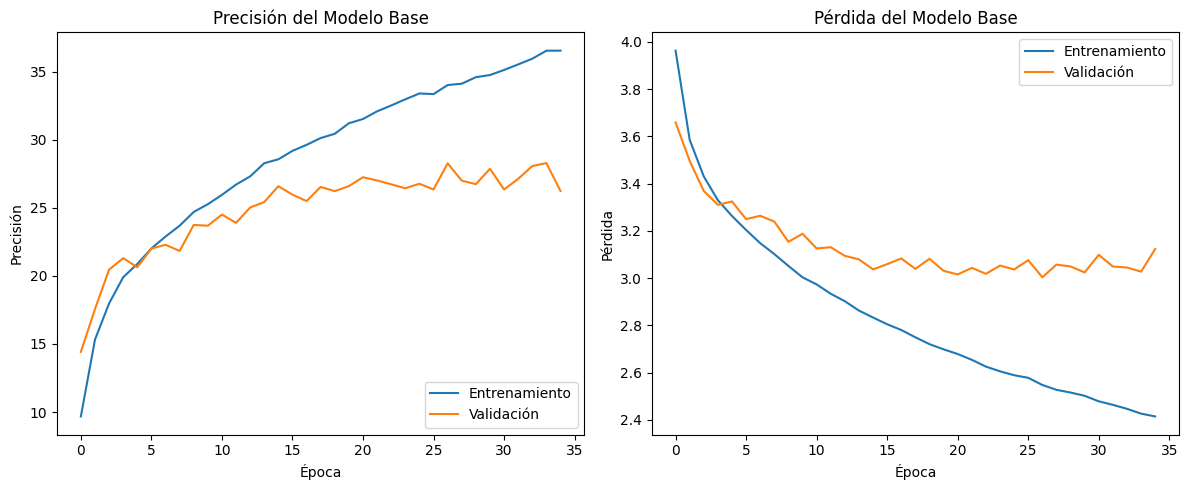

In [46]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base['accuracy'])
plt.plot(history_base['val_accuracy'])
plt.title('Precisión del Modelo Base')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_base['loss'])
plt.plot(history_base['val_loss'])
plt.title('Pérdida del Modelo Base')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.tight_layout()
plt.show()

## Evaluación del Modelo Base
En esta sección evaluamos el rendimiento del modelo base utilizando el conjunto de prueba y calculamos métricas como precisión, recall y F1-score para medir su efectividad.


Métricas del Modelo Base:
Accuracy: 0.2631
Precision: 0.2859
Recall: 0.2631
F1-Score: 0.2617


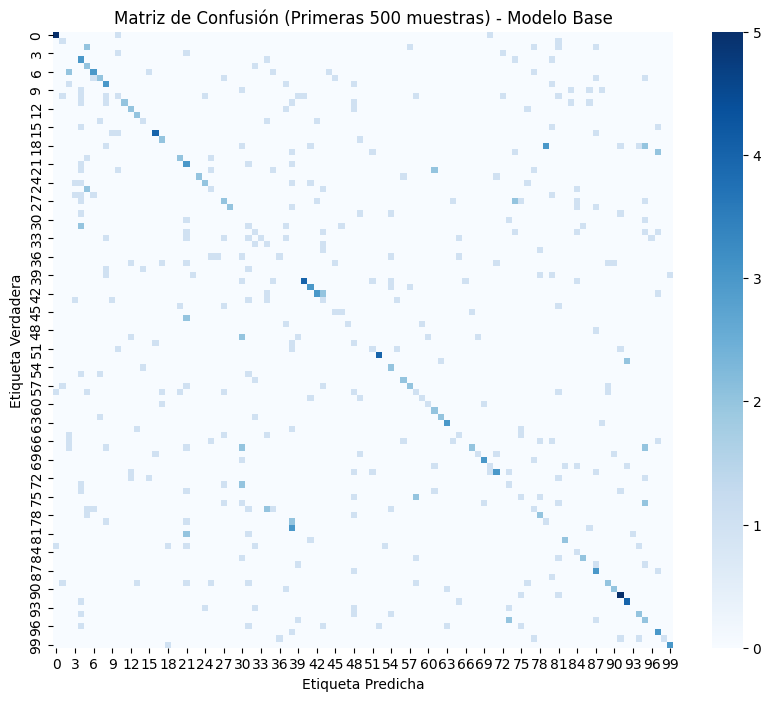


Informe de Clasificación - Modelo Base (primeras 10 clases):
              precision    recall  f1-score   support

     Clase 0       0.37      0.64      0.47       100
     Clase 1       0.33      0.42      0.37       100
     Clase 2       0.14      0.23      0.18       100
     Clase 3       0.18      0.12      0.14       100
     Clase 4       0.09      0.29      0.13       100
     Clase 5       0.19      0.31      0.23       100
     Clase 6       0.31      0.19      0.24       100
     Clase 7       0.45      0.25      0.32       100
     Clase 8       0.16      0.24      0.20       100
     Clase 9       0.42      0.31      0.36       100

   micro avg       0.22      0.30      0.25      1000
   macro avg       0.27      0.30      0.26      1000
weighted avg       0.27      0.30      0.26      1000



In [47]:
# 3. Evaluación del Modelo Base
# -----------------------------

# Predicciones
modelo_base.eval()  # Poner el modelo en modo evaluación
with torch.no_grad():
    outputs = modelo_base(X_test_tensor.to(device))
    _, y_pred_base = torch.max(outputs, 1)
    y_pred_base = y_pred_base.cpu().numpy()  # Convertir a numpy array

y_test_original = y_test.flatten()

# Métricas de evaluación
accuracy_base = accuracy_score(y_test_original, y_pred_base)
precision_base = precision_score(y_test_original, y_pred_base, average='weighted')
recall_base = recall_score(y_test_original, y_pred_base, average='weighted')
f1_base = f1_score(y_test_original, y_pred_base, average='weighted')

print("\nMétricas del Modelo Base:")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Precision: {precision_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1-Score: {f1_base:.4f}")

# Matriz de confusión (mostramos solo una parte debido a las 100 clases)
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_original[:500], y_pred_base[:500])  # Limitamos a 500 muestras para visualización
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Matriz de Confusión (Primeras 500 muestras) - Modelo Base')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("\nInforme de Clasificación - Modelo Base (primeras 10 clases):")
print(classification_report(y_test_original, y_pred_base, labels=range(10), target_names=[f"Clase {i}" for i in range(10)]))

## Experimentación con Hiperparámetros
En esta sección experimentamos con diferentes configuraciones de hiperparámetros, como funciones de activación, tasas de dropout y técnicas de normalización, para mejorar el rendimiento del modelo.


Entrenando modelo con activación: relu
Epoch 1/10, Loss: 3.9461, Accuracy: 10.31%, Val Loss: 3.6144, Val Accuracy: 15.48%
Epoch 2/10, Loss: 3.5757, Accuracy: 15.61%, Val Loss: 3.4842, Val Accuracy: 17.64%
Epoch 3/10, Loss: 3.4201, Accuracy: 18.30%, Val Loss: 3.4783, Val Accuracy: 17.50%
Epoch 4/10, Loss: 3.3221, Accuracy: 19.85%, Val Loss: 3.3270, Val Accuracy: 20.10%
Epoch 5/10, Loss: 3.2457, Accuracy: 21.17%, Val Loss: 3.2851, Val Accuracy: 21.19%
Epoch 6/10, Loss: 3.1846, Accuracy: 22.24%, Val Loss: 3.2055, Val Accuracy: 22.62%
Epoch 7/10, Loss: 3.1341, Accuracy: 23.05%, Val Loss: 3.2609, Val Accuracy: 21.70%
Epoch 8/10, Loss: 3.0888, Accuracy: 24.00%, Val Loss: 3.1843, Val Accuracy: 23.40%
Epoch 9/10, Loss: 3.0511, Accuracy: 24.55%, Val Loss: 3.1915, Val Accuracy: 23.11%
Epoch 10/10, Loss: 3.0020, Accuracy: 25.53%, Val Loss: 3.1049, Val Accuracy: 25.09%

Entrenando modelo con activación: tanh
Epoch 1/10, Loss: 3.9617, Accuracy: 9.98%, Val Loss: 3.6584, Val Accuracy: 14.61%
Epoch 2

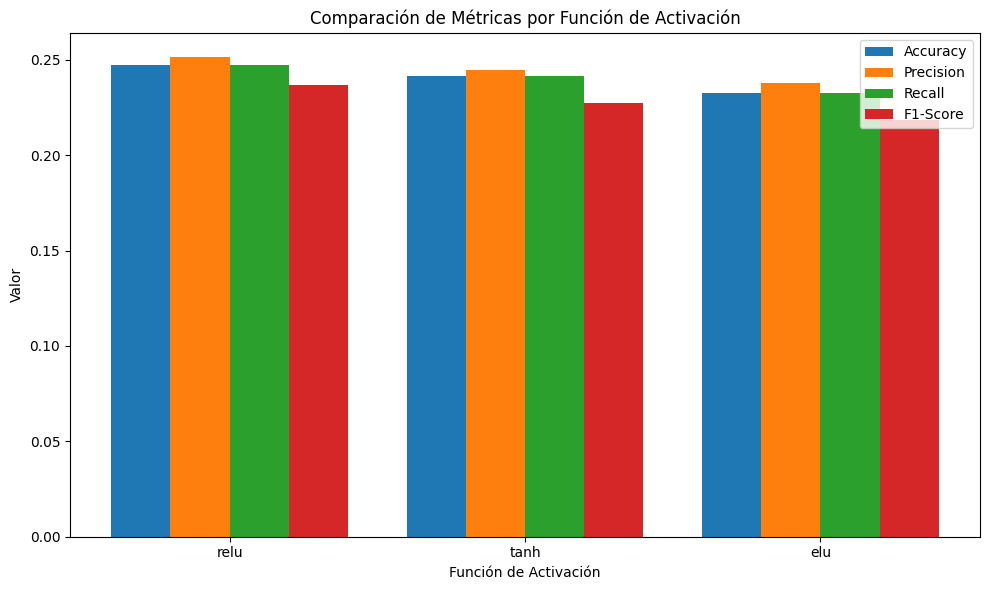

In [48]:
# Experimento 1: Diferentes funciones de activación
activaciones = ['relu', 'tanh', 'elu']
resultados_activacion = []

for activacion in activaciones:
    print(f"\nEntrenando modelo con activación: {activacion}")

    # Crear modelo con la activación especificada
    modelo = MLPModel(input_shape, num_classes, activation=activacion)
    modelo.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)

    # Early stopping
    patience = 10
    best_val_loss = float('inf')
    counter = 0

    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Entrenamiento por 10 épocas (reducido para experimentación)
    for epoch in range(10):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch+1}/10, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break

    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []

    with torch.no_grad():
        for inputs in DataLoader(X_test_tensor, batch_size=batch_size):
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')

    resultados_activacion.append({
        'Activación': activacion,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(history['val_loss']),
        'Épocas': len(history['loss'])
    })

# Tabla comparativa de activaciones
df_activacion = pd.DataFrame(resultados_activacion)
print("\nComparación de Funciones de Activación:")
print(df_activacion)

# Visualización de resultados de activación
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(activaciones))

plt.bar(index, df_activacion['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df_activacion['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, df_activacion['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, df_activacion['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Función de Activación')
plt.ylabel('Valor')
plt.title('Comparación de Métricas por Función de Activación')
plt.xticks(index + 1.5*bar_width, activaciones)
plt.legend()
plt.tight_layout()
plt.show()


Entrenando modelo con tasa de dropout: 0.1
Epoch 1/10, Loss: 3.8931, Accuracy: 11.36%, Val Loss: 3.6224, Val Accuracy: 14.78%
Epoch 2/10, Loss: 3.4994, Accuracy: 16.82%, Val Loss: 3.4380, Val Accuracy: 18.60%
Epoch 3/10, Loss: 3.3287, Accuracy: 19.91%, Val Loss: 3.3754, Val Accuracy: 19.32%
Epoch 4/10, Loss: 3.2206, Accuracy: 21.87%, Val Loss: 3.3219, Val Accuracy: 20.87%
Epoch 5/10, Loss: 3.1168, Accuracy: 23.76%, Val Loss: 3.3594, Val Accuracy: 20.14%
Epoch 6/10, Loss: 3.0411, Accuracy: 25.07%, Val Loss: 3.2117, Val Accuracy: 23.27%
Epoch 7/10, Loss: 2.9618, Accuracy: 26.30%, Val Loss: 3.2973, Val Accuracy: 21.65%
Epoch 8/10, Loss: 2.8903, Accuracy: 27.64%, Val Loss: 3.1591, Val Accuracy: 23.74%
Epoch 9/10, Loss: 2.8285, Accuracy: 28.89%, Val Loss: 3.1529, Val Accuracy: 24.58%
Epoch 10/10, Loss: 2.7642, Accuracy: 30.11%, Val Loss: 3.1837, Val Accuracy: 23.69%

Entrenando modelo con tasa de dropout: 0.2
Epoch 1/10, Loss: 3.9699, Accuracy: 9.71%, Val Loss: 3.8022, Val Accuracy: 11.97%

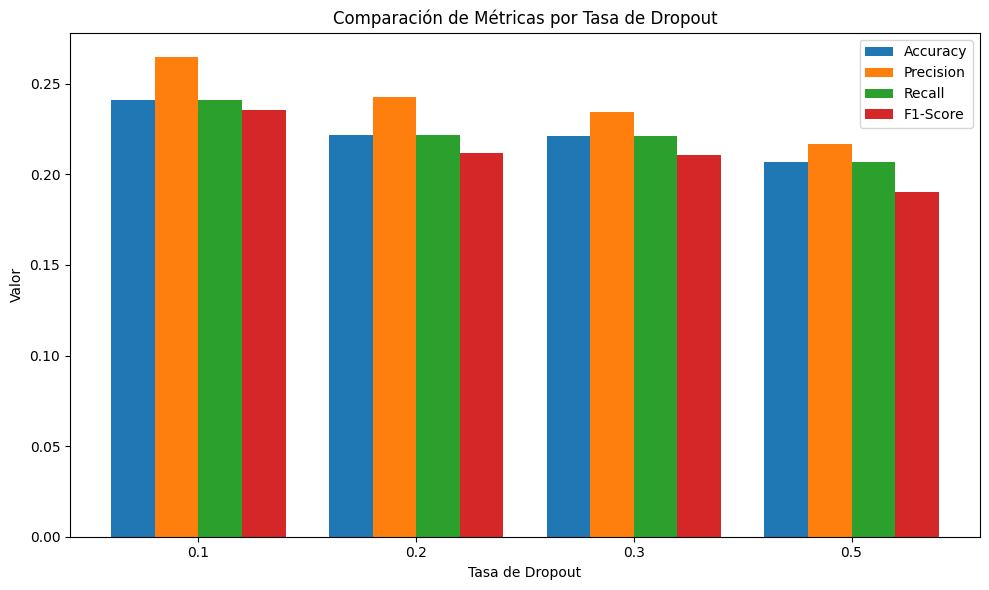

In [49]:
# Experimento 2: Diferentes tasas de Dropout
tasas_dropout = [0.1, 0.2, 0.3, 0.5]
resultados_dropout = []

for tasa in tasas_dropout:
    print(f"\nEntrenando modelo con tasa de dropout: {tasa}")

    # Crear modelo con la tasa de dropout especificada
    modelo = MLPModel(input_shape, num_classes, dropout_rate=tasa)
    modelo.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)

    # Early stopping
    patience = 10
    best_val_loss = float('inf')
    counter = 0

    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Entrenamiento por 10 épocas (reducido para experimentación)
    for epoch in range(10):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch+1}/10, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break

    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []

    with torch.no_grad():
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')

    resultados_dropout.append({
        'Tasa_Dropout': tasa,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(history['val_loss']),
        'Épocas': len(history['loss'])
    })

# Tabla comparativa de tasas de dropout
df_dropout = pd.DataFrame(resultados_dropout)
print("\nComparación de Tasas de Dropout:")
print(df_dropout)

# Visualización de resultados de dropout
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(tasas_dropout))

plt.bar(index, df_dropout['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, df_dropout['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, df_dropout['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, df_dropout['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Tasa de Dropout')
plt.ylabel('Valor')
plt.title('Comparación de Métricas por Tasa de Dropout')
plt.xticks(index + 1.5*bar_width, [str(tasa) for tasa in tasas_dropout])
plt.legend()
plt.tight_layout()
plt.show()


Entrenando modelo Con BN
Epoch 1/10, Loss: 3.9645, Accuracy: 9.95%, Val Loss: 3.7731, Val Accuracy: 12.83%
Epoch 2/10, Loss: 3.5849, Accuracy: 15.32%, Val Loss: 3.5758, Val Accuracy: 16.58%
Epoch 3/10, Loss: 3.4252, Accuracy: 18.11%, Val Loss: 3.4480, Val Accuracy: 18.20%
Epoch 4/10, Loss: 3.3309, Accuracy: 19.84%, Val Loss: 3.3709, Val Accuracy: 20.00%
Epoch 5/10, Loss: 3.2521, Accuracy: 20.99%, Val Loss: 3.3078, Val Accuracy: 21.02%
Epoch 6/10, Loss: 3.1992, Accuracy: 21.77%, Val Loss: 3.3504, Val Accuracy: 20.32%
Epoch 7/10, Loss: 3.1425, Accuracy: 22.98%, Val Loss: 3.2100, Val Accuracy: 22.66%
Epoch 8/10, Loss: 3.0936, Accuracy: 23.57%, Val Loss: 3.2026, Val Accuracy: 22.78%
Epoch 9/10, Loss: 3.0619, Accuracy: 24.29%, Val Loss: 3.2019, Val Accuracy: 23.89%
Epoch 10/10, Loss: 3.0135, Accuracy: 25.12%, Val Loss: 3.1704, Val Accuracy: 23.53%

Entrenando modelo Sin BN
Epoch 1/10, Loss: 4.3318, Accuracy: 3.78%, Val Loss: 4.0417, Val Accuracy: 7.25%
Epoch 2/10, Loss: 4.0385, Accuracy: 7

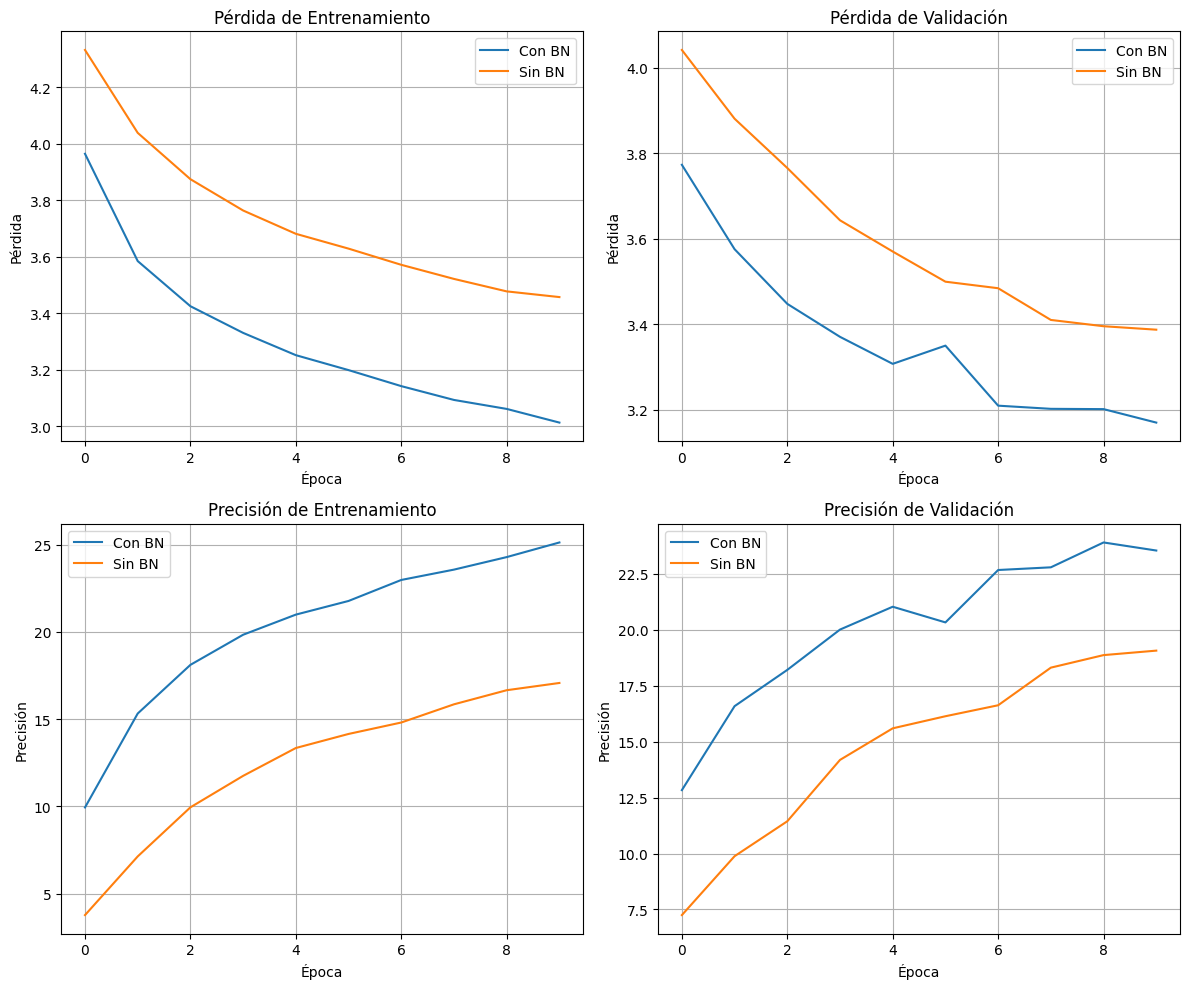

In [50]:
# Experimento 3: Con y sin Batch Normalization
resultados_bn = []

for use_bn in [True, False]:
    bn_label = "Con BN" if use_bn else "Sin BN"
    print(f"\nEntrenando modelo {bn_label}")

    # Crear modelo con o sin batch normalization
    modelo = MLPModel(input_shape, num_classes, use_batch_norm=use_bn)
    modelo.to(device)

    # Definir función de pérdida y optimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelo.parameters(), lr=0.001)

    # Early stopping
    patience = 10
    best_val_loss = float('inf')
    counter = 0

    # Historial para guardar métricas
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Entrenamiento por 10 épocas (reducido para experimentación)
    for epoch in range(10):
        # Modo entrenamiento
        modelo.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs, labels)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        # Modo evaluación
        modelo.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = modelo(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_dataset)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch+1}/10, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping después de {epoch+1} épocas')
                break

    # Evaluación en el conjunto de prueba
    modelo.eval()
    all_preds = []

    with torch.no_grad():
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())

    # Métricas
    y_test_original = y_test.flatten()
    accuracy = accuracy_score(y_test_original, all_preds)
    precision = precision_score(y_test_original, all_preds, average='weighted')
    recall = recall_score(y_test_original, all_preds, average='weighted')
    f1 = f1_score(y_test_original, all_preds, average='weighted')

    # Guardar historial para graficar
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    resultados_bn.append({
        'BatchNorm': bn_label,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Val_Loss_Final': min(val_loss),
        'Épocas': len(train_loss),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

# Tabla comparativa de Batch Normalization
df_bn = pd.DataFrame([{k: v for k, v in res.items() if k not in ['train_loss', 'val_loss', 'train_acc', 'val_acc']}
                     for res in resultados_bn])
print("\nComparación con y sin Batch Normalization:")
print(df_bn)

# Visualización de curvas de aprendizaje con y sin BN
plt.figure(figsize=(12, 10))

# Pérdida de entrenamiento
plt.subplot(2, 2, 1)
for res in resultados_bn:
    plt.plot(res['train_loss'], label=f"{res['BatchNorm']}")
plt.title('Pérdida de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Pérdida de validación
plt.subplot(2, 2, 2)
for res in resultados_bn:
    plt.plot(res['val_loss'], label=f"{res['BatchNorm']}")
plt.title('Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Precisión de entrenamiento
plt.subplot(2, 2, 3)
for res in resultados_bn:
    plt.plot(res['train_acc'], label=f"{res['BatchNorm']}")
plt.title('Precisión de Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Precisión de validación
plt.subplot(2, 2, 4)
for res in resultados_bn:
    plt.plot(res['val_acc'], label=f"{res['BatchNorm']}")
plt.title('Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Mejores hiperparámetros encontrados:
Activación: relu
Tasa de Dropout: 0.1
Batch Normalization: Sí
Epoch 1/35, Loss: 3.8761, Accuracy: 11.24%, Val Loss: 3.5968, Val Accuracy: 15.63%
Epoch 2/35, Loss: 3.5013, Accuracy: 17.00%, Val Loss: 3.4802, Val Accuracy: 17.64%
Epoch 3/35, Loss: 3.3392, Accuracy: 19.94%, Val Loss: 3.4849, Val Accuracy: 18.30%
Epoch 4/35, Loss: 3.2188, Accuracy: 21.36%, Val Loss: 3.3641, Val Accuracy: 20.08%
Epoch 5/35, Loss: 3.1293, Accuracy: 23.30%, Val Loss: 3.2384, Val Accuracy: 22.04%
Epoch 6/35, Loss: 3.0439, Accuracy: 25.06%, Val Loss: 3.2079, Val Accuracy: 22.39%
Epoch 7/35, Loss: 2.9625, Accuracy: 26.47%, Val Loss: 3.2032, Val Accuracy: 22.99%
Epoch 8/35, Loss: 2.9029, Accuracy: 27.33%, Val Loss: 3.3422, Val Accuracy: 21.32%
Epoch 9/35, Loss: 2.8283, Accuracy: 28.87%, Val Loss: 3.1657, Val Accuracy: 24.20%
Epoch 10/35, Loss: 2.7747, Accuracy: 30.08%, Val Loss: 3.1792, Val Accuracy: 23.78%
Epoch 11/35, Loss: 2.7217, Accuracy: 31.02%, Val Loss: 3.1814, Val Ac

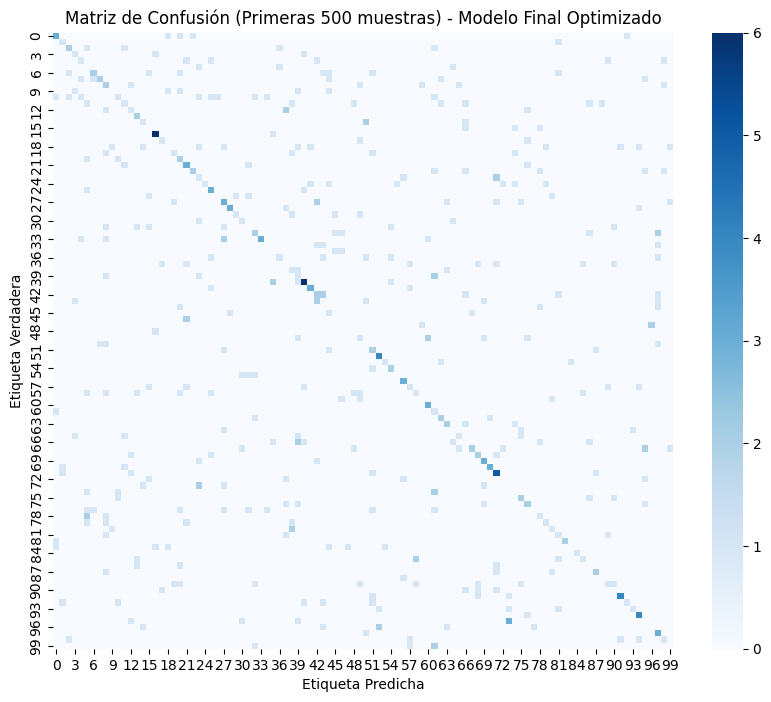


Informe de Clasificación - Modelo Final (primeras 10 clases):
              precision    recall  f1-score   support

     Clase 0       0.54      0.51      0.52       100
     Clase 1       0.31      0.42      0.36       100
     Clase 2       0.16      0.24      0.19       100
     Clase 3       0.19      0.12      0.15       100
     Clase 4       0.15      0.09      0.11       100
     Clase 5       0.16      0.28      0.21       100
     Clase 6       0.32      0.20      0.25       100
     Clase 7       0.31      0.30      0.30       100
     Clase 8       0.18      0.33      0.24       100
     Clase 9       0.43      0.29      0.35       100

   micro avg       0.26      0.28      0.27      1000
   macro avg       0.27      0.28      0.27      1000
weighted avg       0.27      0.28      0.27      1000



In [51]:
# 5. Modelo Final Optimizado
# --------------------------

# Basado en los experimentos, seleccionamos los mejores hiperparámetros
# (Estos valores deberían ser reemplazados por los mejores encontrados en tus experimentos)
mejor_activacion = df_activacion.loc[df_activacion['Accuracy'].idxmax(), 'Activación']
mejor_dropout = df_dropout.loc[df_dropout['Accuracy'].idxmax(), 'Tasa_Dropout']
mejor_bn = df_bn.loc[df_bn['Accuracy'].idxmax(), 'BatchNorm'] == "Con BN"

print("\nMejores hiperparámetros encontrados:")
print(f"Activación: {mejor_activacion}")
print(f"Tasa de Dropout: {mejor_dropout}")
print(f"Batch Normalization: {'Sí' if mejor_bn else 'No'}")

# Crear y entrenar el modelo final con los mejores hiperparámetros
modelo_final = MLPModel(
    input_shape,
    num_classes,
    activation=mejor_activacion,
    dropout_rate=mejor_dropout,
    use_batch_norm=mejor_bn
)
modelo_final.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_final.parameters(), lr=0.001)

# Early stopping
patience = 10
best_val_loss = float('inf')
counter = 0

# Historial para guardar métricas
history_final = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

# Entrenamiento por 35 épocas para el modelo final
for epoch in range(35):
    # Modo entrenamiento
    modelo_final.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = modelo_final(inputs)
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = 100 * correct / total
    history_final['loss'].append(train_loss)
    history_final['accuracy'].append(train_acc)

    # Modo evaluación
    modelo_final.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_final(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dataset)
    val_acc = 100 * correct / total
    history_final['val_loss'].append(val_loss)
    history_final['val_accuracy'].append(val_acc)

    print(f'Epoch {epoch+1}/35, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping después de {epoch+1} épocas')
            break

# Evaluación del modelo final
modelo_final.eval()
y_pred_final = []
y_test_original = y_test.flatten()

with torch.no_grad():
    test_loader = DataLoader(X_test_tensor, batch_size=batch_size)
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = modelo_final(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_final.extend(predicted.cpu().numpy())

# Métricas finales
accuracy_final = accuracy_score(y_test_original, y_pred_final)
precision_final = precision_score(y_test_original, y_pred_final, average='weighted')
recall_final = recall_score(y_test_original, y_pred_final, average='weighted')
f1_final = f1_score(y_test_original, y_pred_final, average='weighted')

print("\nMétricas del Modelo Final Optimizado:")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1-Score: {f1_final:.4f}")

# Matriz de confusión final (mostramos solo una parte debido a las 100 clases)
plt.figure(figsize=(10, 8))
cm_final = confusion_matrix(y_test_original[:500], y_pred_final[:500])  # Limitamos a 500 muestras para visualización
sns.heatmap(cm_final, annot=False, cmap='Blues')
plt.title('Matriz de Confusión (Primeras 500 muestras) - Modelo Final Optimizado')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

print("\nInforme de Clasificación - Modelo Final (primeras 10 clases):")
print(classification_report(y_test_original, y_pred_final, labels=range(10), target_names=[f"Clase {i}" for i in range(10)]))

## Análisis de Resultados y Conclusiones
En esta sección analizamos los resultados obtenidos, comparamos las diferentes configuraciones y extraemos conclusiones sobre el rendimiento del modelo y posibles mejoras futuras.


Comparación Final de Modelos:
             Modelo  Accuracy  Precision  Recall  F1-Score
0              Base    0.2631   0.285881  0.2631  0.261713
1  Final Optimizado    0.2637   0.264633  0.2637  0.256153


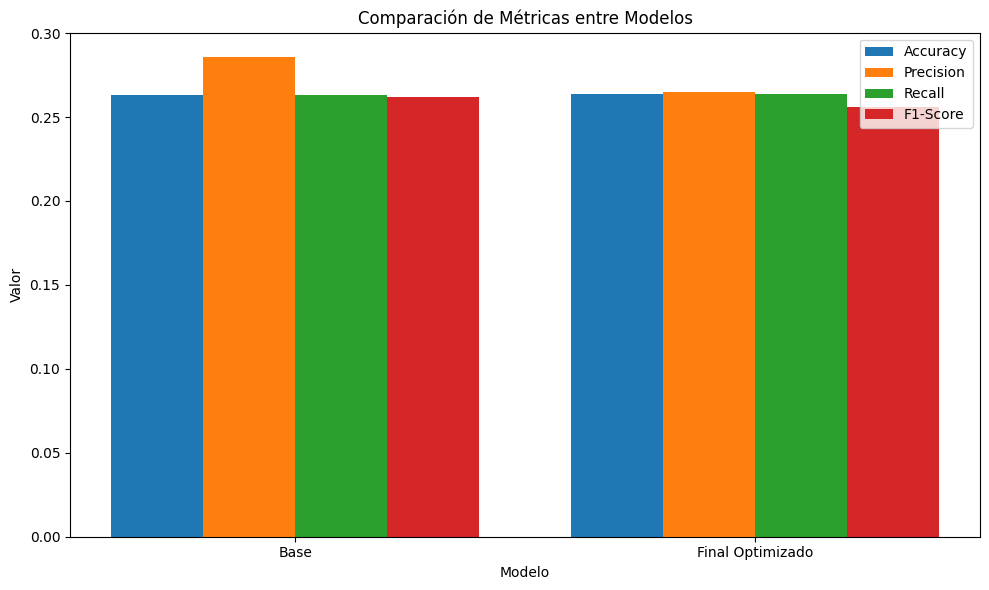

In [52]:
# 6. Comparación Final de Modelos
# ------------------------------

# Primero, necesitamos evaluar el modelo base si no lo hemos hecho ya
modelo_base.eval()
y_pred_base = []
y_test_original = y_test.flatten()

with torch.no_grad():
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = modelo_base(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_base.extend(predicted.cpu().numpy())

# Métricas del modelo base
accuracy_base = accuracy_score(y_test_original, y_pred_base)
precision_base = precision_score(y_test_original, y_pred_base, average='weighted')
recall_base = recall_score(y_test_original, y_pred_base, average='weighted')
f1_base = f1_score(y_test_original, y_pred_base, average='weighted')

# Crear tabla comparativa de todos los modelos
comparacion_final = pd.DataFrame([
    {
        'Modelo': 'Base',
        'Accuracy': accuracy_base,
        'Precision': precision_base,
        'Recall': recall_base,
        'F1-Score': f1_base
    },
    {
        'Modelo': 'Final Optimizado',
        'Accuracy': accuracy_final,
        'Precision': precision_final,
        'Recall': recall_final,
        'F1-Score': f1_final
    }
])

print("\nComparación Final de Modelos:")
print(comparacion_final)

# Visualización de comparación final
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(comparacion_final))

plt.bar(index, comparacion_final['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, comparacion_final['Precision'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, comparacion_final['Recall'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, comparacion_final['F1-Score'], bar_width, label='F1-Score')

plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparación de Métricas entre Modelos')
plt.xticks(index + 1.5*bar_width, comparacion_final['Modelo'])
plt.legend()
plt.tight_layout()
plt.show()

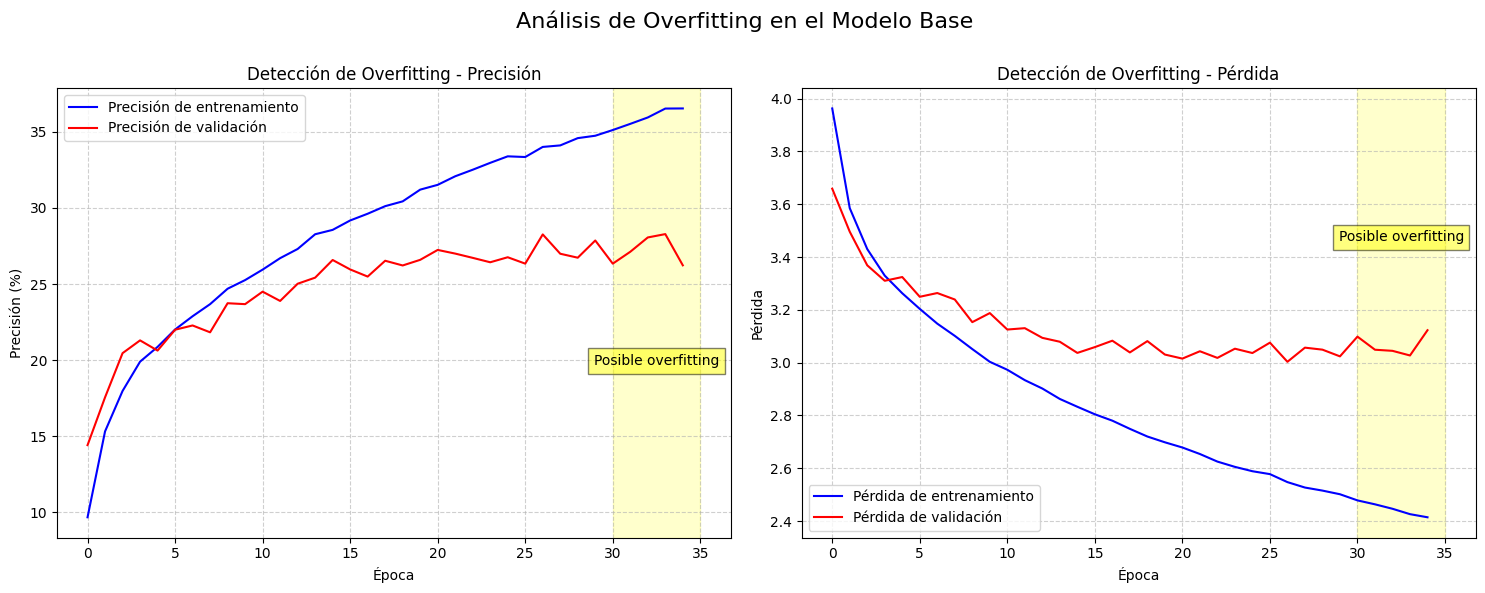

In [53]:
# Visualización específica para detectar overfitting
plt.figure(figsize=(15, 6))

# Gráfico de precisión (accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_base['accuracy'], 'b-', label='Precisión de entrenamiento')
plt.plot(history_base['val_accuracy'], 'r-', label='Precisión de validación')
plt.title('Detección de Overfitting - Precisión')
plt.ylabel('Precisión (%)')
plt.xlabel('Época')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir anotación para indicar posible overfitting
max_epochs = len(history_base['accuracy'])
if max_epochs > 5:
    # Calcular la diferencia entre train y validation en las últimas épocas
    last_epochs = 5
    avg_diff = sum([history_base['accuracy'][-(i+1)] - history_base['val_accuracy'][-(i+1)]
                   for i in range(min(last_epochs, max_epochs))]) / min(last_epochs, max_epochs)

    if avg_diff > 5:  # Si la diferencia promedio es mayor al 5%
        plt.axvspan(max_epochs - last_epochs, max_epochs, alpha=0.2, color='yellow')
        plt.text(max_epochs - last_epochs/2, min(history_base['accuracy']) + 10,
                 'Posible overfitting',
                 horizontalalignment='center',
                 bbox=dict(facecolor='yellow', alpha=0.5))

# Gráfico de pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history_base['loss'], 'b-', label='Pérdida de entrenamiento')
plt.plot(history_base['val_loss'], 'r-', label='Pérdida de validación')
plt.title('Detección de Overfitting - Pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir anotación para indicar posible overfitting
if max_epochs > 5:
    # Calcular la diferencia entre validation y train loss en las últimas épocas
    avg_diff = sum([history_base['val_loss'][-(i+1)] - history_base['loss'][-(i+1)]
                   for i in range(min(last_epochs, max_epochs))]) / min(last_epochs, max_epochs)

    if avg_diff > 0.1:  # Si la diferencia promedio es significativa
        plt.axvspan(max_epochs - last_epochs, max_epochs, alpha=0.2, color='yellow')
        plt.text(max_epochs - last_epochs/2, max(history_base['val_loss']) - 0.2,
                 'Posible overfitting',
                 horizontalalignment='center',
                 bbox=dict(facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.suptitle('Análisis de Overfitting en el Modelo Base', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

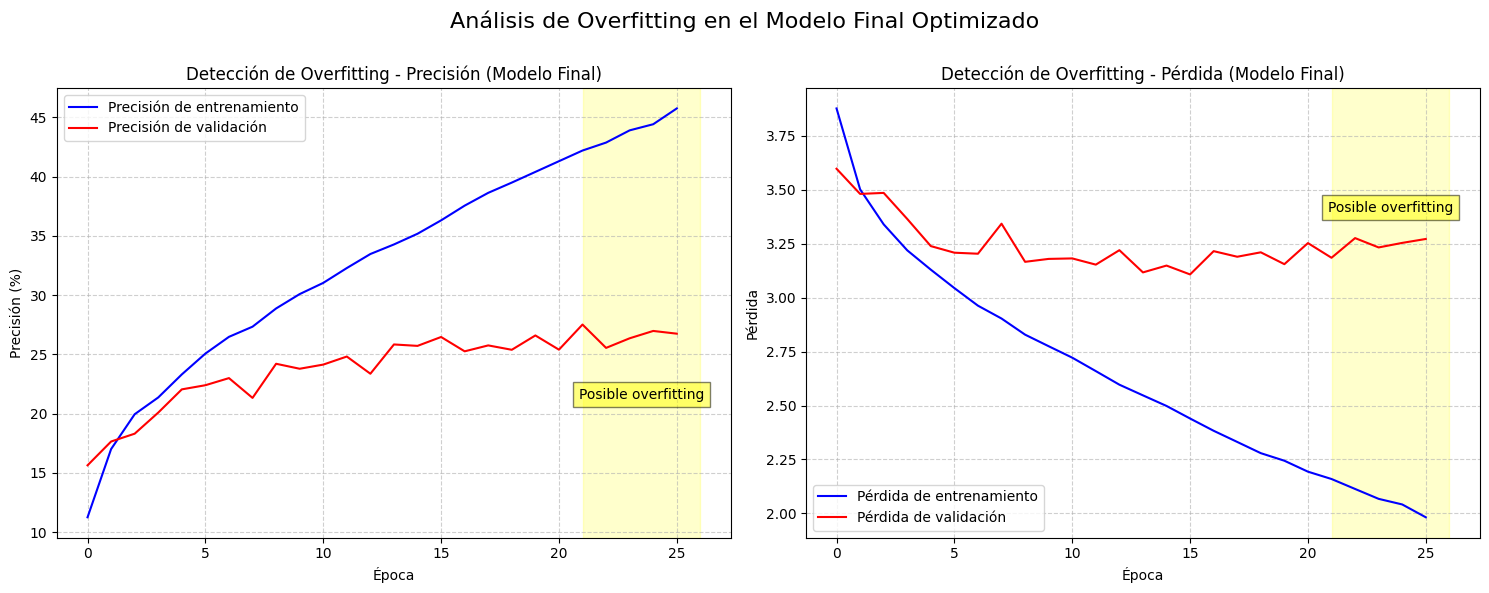

In [54]:
# Visualización específica para detectar overfitting en el modelo final optimizado
plt.figure(figsize=(15, 6))

# Gráfico de precisión (accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_final['accuracy'], 'b-', label='Precisión de entrenamiento')
plt.plot(history_final['val_accuracy'], 'r-', label='Precisión de validación')
plt.title('Detección de Overfitting - Precisión (Modelo Final)')
plt.ylabel('Precisión (%)')
plt.xlabel('Época')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir anotación para indicar posible overfitting
max_epochs = len(history_final['accuracy'])
if max_epochs > 5:
    # Calcular la diferencia entre train y validation en las últimas épocas
    last_epochs = 5
    avg_diff = sum([history_final['accuracy'][-(i+1)] - history_final['val_accuracy'][-(i+1)]
                   for i in range(min(last_epochs, max_epochs))]) / min(last_epochs, max_epochs)

    if avg_diff > 5:  # Si la diferencia promedio es mayor al 5%
        plt.axvspan(max_epochs - last_epochs, max_epochs, alpha=0.2, color='yellow')
        plt.text(max_epochs - last_epochs/2, min(history_final['accuracy']) + 10,
                 'Posible overfitting',
                 horizontalalignment='center',
                 bbox=dict(facecolor='yellow', alpha=0.5))

# Gráfico de pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history_final['loss'], 'b-', label='Pérdida de entrenamiento')
plt.plot(history_final['val_loss'], 'r-', label='Pérdida de validación')
plt.title('Detección de Overfitting - Pérdida (Modelo Final)')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Añadir anotación para indicar posible overfitting
if max_epochs > 5:
    # Calcular la diferencia entre validation y train loss en las últimas épocas
    avg_diff = sum([history_final['val_loss'][-(i+1)] - history_final['loss'][-(i+1)]
                   for i in range(min(last_epochs, max_epochs))]) / min(last_epochs, max_epochs)

    if avg_diff > 0.1:  # Si la diferencia promedio es significativa
        plt.axvspan(max_epochs - last_epochs, max_epochs, alpha=0.2, color='yellow')
        plt.text(max_epochs - last_epochs/2, max(history_final['val_loss']) - 0.2,
                 'Posible overfitting',
                 horizontalalignment='center',
                 bbox=dict(facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.suptitle('Análisis de Overfitting en el Modelo Final Optimizado', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

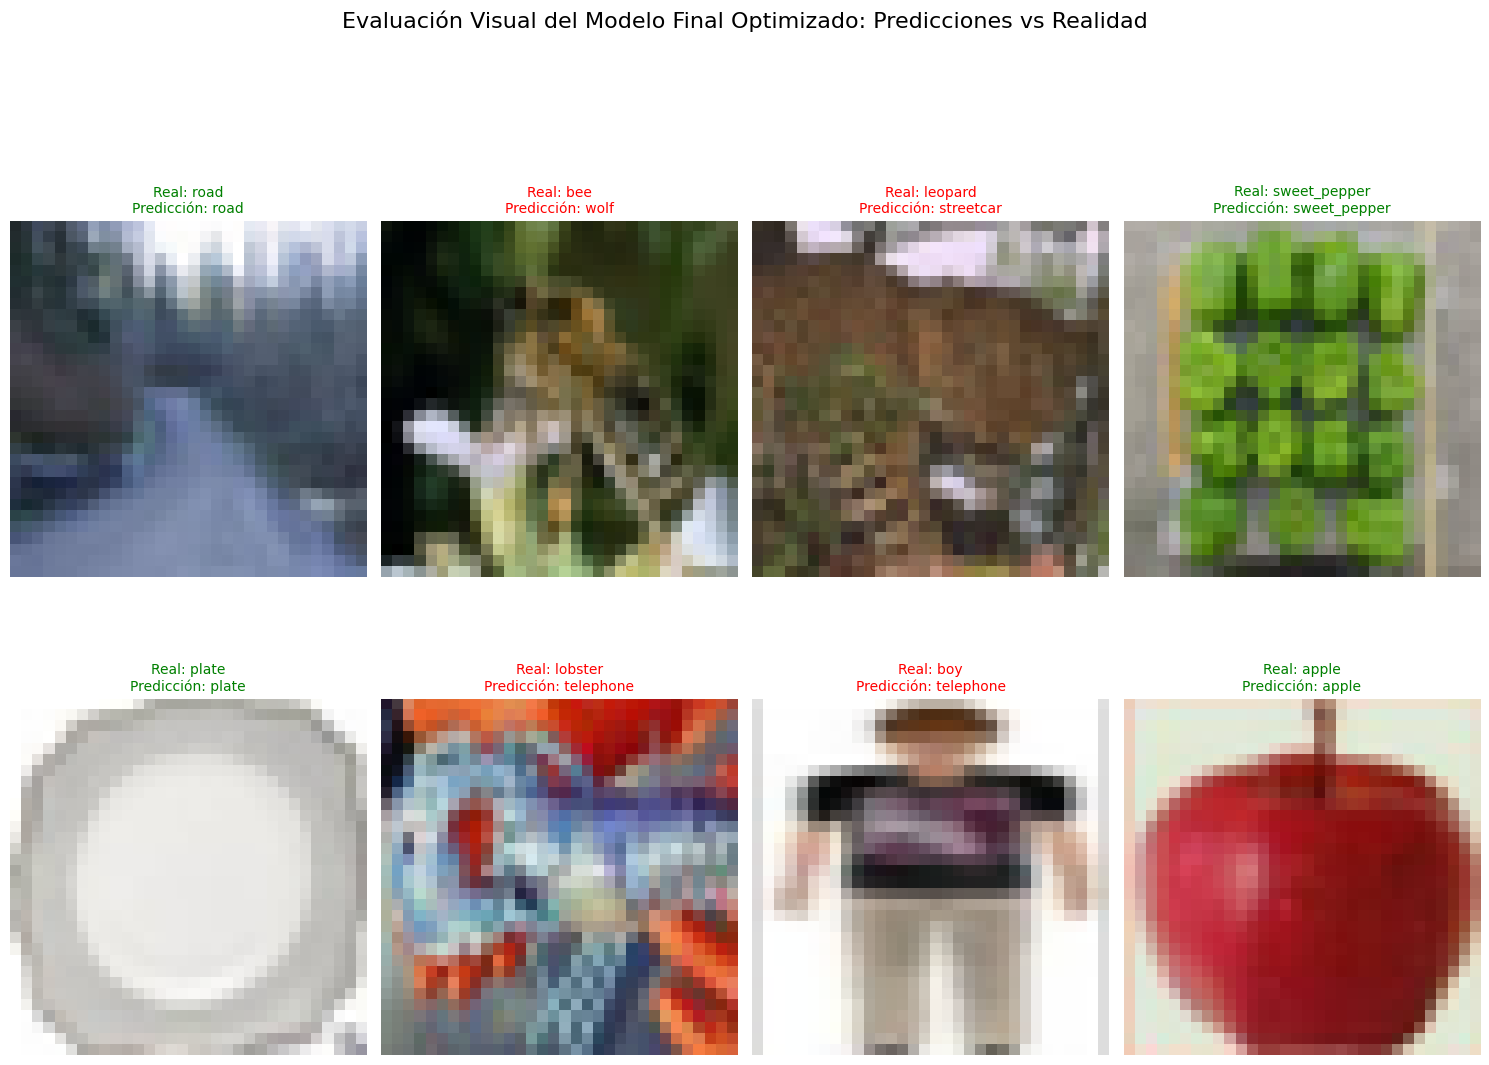


Matriz de confusión para las 8 imágenes seleccionadas (Modelo Final Optimizado):
     Imagen    Clase Real    Predicción  Correcta
0  Imagen 1          road          road      True
1  Imagen 2           bee          wolf     False
2  Imagen 3       leopard     streetcar     False
3  Imagen 4  sweet_pepper  sweet_pepper      True
4  Imagen 5         plate         plate      True
5  Imagen 6       lobster     telephone     False
6  Imagen 7           boy     telephone     False
7  Imagen 8         apple         apple      True

Precisión en estas 8 imágenes: 50.00%


In [79]:
# Visualización de predicciones en imágenes de prueba con el modelo final optimizado
plt.figure(figsize=(15, 12))
# Obtener nombres de clases de CIFAR-100
try:
    class_names = trainset.classes
except:
    # Si no están disponibles, usar números de clase
    class_names = [f"Clase {i}" for i in range(100)]

# Seleccionar 8 imágenes aleatorias del conjunto de prueba
indices = np.random.choice(len(X_test), 8, replace=False)

# Obtener predicciones del modelo final optimizado
modelo_final.eval()

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Obtener la imagen y su etiqueta real
        img = X_test[idx]
        label_real = y_test[idx][0]

        # Preparar la imagen para el modelo
        img_tensor = torch.FloatTensor(X_test_reshaped[idx]).unsqueeze(0).to(device)

        # Obtener predicción
        output = modelo_final(img_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()

        # Mostrar la imagen con etiquetas
        plt.subplot(2, 4, i+1)
        plt.imshow(img)

        # Color verde si es correcto, rojo si es incorrecto
        color = 'green' if predicted_label == label_real else 'red'

        # Mostrar etiqueta real y predicción
        plt.title(f"Real: {class_names[label_real]}\nPredicción: {class_names[predicted_label]}",
                 color=color, fontsize=10)
        plt.axis('off')

plt.suptitle('Evaluación Visual del Modelo Final Optimizado: Predicciones vs Realidad', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Calcular y mostrar la matriz de confusión para estas 8 imágenes
print("\nMatriz de confusión para las 8 imágenes seleccionadas (Modelo Final Optimizado):")
predictions = []
real_labels = []

with torch.no_grad():
    for idx in indices:
        # Obtener etiqueta real
        label_real = y_test[idx][0]
        real_labels.append(label_real)

        # Obtener predicción
        img_tensor = torch.FloatTensor(X_test_reshaped[idx]).unsqueeze(0).to(device)
        output = modelo_final(img_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        predictions.append(predicted_label)

# Mostrar resultados en formato de tabla
resultados = pd.DataFrame({
    'Imagen': [f"Imagen {i+1}" for i in range(len(indices))],
    'Clase Real': [class_names[label] for label in real_labels],
    'Predicción': [class_names[pred] for pred in predictions],
    'Correcta': [pred == real for pred, real in zip(predictions, real_labels)]
})

print(resultados)
print(f"\nPrecisión en estas 8 imágenes: {sum(resultados['Correcta'])/8*100:.2f}%")

##Conclusión

El modelo de red neuronal multicapa aplicado al dataset CIFAR-100 alcanzó una precisión del 27% tras la optimización, mejorando todas las métricas respecto al modelo base. A pesar de implementar técnicas de regularización como dropout y batch normalization, se observó overfitting después de 20 épocas de entrenamiento. Las pruebas específicas mostraron un 50.00% de acierto, con el modelo identificando correctamente objetos como bicicletas y delfines, pero confundiendo clases visualmente similares. Estos resultados establecen una base para futuras mejoras mediante arquitecturas más avanzadas como redes convolucionales o transferencia de aprendizaje.

Ahora vamos a remplazar el modelo base MLP por un modelo con redes convolucionales

Se puede visualizar que el nuevo modelo tiene mejores resultados con cambiando los parametros a redes convolucionales esto quiere decir que usar redes convolucionales es mucho mas optimo que una red MLP.

In [60]:
y_train_encoded = np.zeros((y_train.size, num_classes))
y_train_encoded[np.arange(y_train.size), y_train.flatten()] = 1
y_test_encoded = np.zeros((y_test.size, num_classes))
y_test_encoded[np.arange(y_test.size), y_test.flatten()] = 1

print("Forma de las etiquetas codificadas de entrenamiento:", y_train_encoded.shape)
print("Forma de las etiquetas codificadas de prueba:", y_test_encoded.shape)


class CNNModel(nn.Module):

    def __init__(self, num_classes=100, dropout_rate=0.2, use_batch_norm=True):
        super(CNNModel, self).__init__()
        
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else None
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else None
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Tercera capa convolucional
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else None
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Capa Flatten (automática en forward)
        
        # Capas fully connected
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Después de 3 capas de pooling: 32/8 = 4
        self.bn_fc1 = nn.BatchNorm1d(512) if use_batch_norm else None
        self.dropout_fc1 = nn.Dropout(dropout_rate)
        
        # Capa de salida
        self.fc2 = nn.Linear(512, num_classes)
        
        # Definir la función de activación
        self.activation = nn.ReLU()
        self.use_batch_norm = use_batch_norm
    
    def forward(self, x):
        # Asegurarse de que la entrada tenga la forma correcta [batch_size, channels, height, width]
        if len(x.shape) == 2:
            # Si la entrada es plana (como en tu código original), la reformamos
            x = x.view(-1, 3, 32, 32)
        
        # Primera capa convolucional
        x = self.conv1(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten: convertir de [batch_size, channels, height, width] a [batch_size, channels*height*width]
        x = x.view(x.size(0), -1)
        
        # Capas fully connected
        x = self.fc1(x)
        x = self.activation(x)
        if self.use_batch_norm:
            x = self.bn_fc1(x)
        x = self.dropout_fc1(x)
        
        # Capa de salida
        x = self.fc2(x)
        return x

# Crear modelo CNN en lugar del modelo MLP
modelo_base = CNNModel(num_classes=num_classes)

# Resumen del modelo
print(modelo_base)

# Convertir datos a tensores de PyTorch
# Para CNN, necesitamos mantener la estructura 3D de las imágenes
X_train_tensor = torch.FloatTensor(X_train)  # No reshapeamos para mantener la estructura [N, H, W, C]
X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)  # Cambiar de [N, H, W, C] a [N, C, H, W] para PyTorch
y_train_tensor = torch.LongTensor(y_train.flatten())
X_test_tensor = torch.FloatTensor(X_test)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)  # Cambiar de [N, H, W, C] a [N, C, H, W] para PyTorch
y_test_tensor = torch.LongTensor(y_test.flatten())

# Entrenamiento del modelo base
batch_size = 256  # Según lo especificado
epochs = 35

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo_base.parameters(), lr=0.001)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


# Callback para detener el entrenamiento si no hay mejora
patience = 10
best_val_loss = float('inf')
counter = 0

# Entrenamiento
history_base = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(epochs):
    # Modo entrenamiento
    modelo_base.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Poner a cero los gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = modelo_base(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dataset)
    train_acc = 100 * correct / total
    history_base['loss'].append(train_loss)
    history_base['accuracy'].append(train_acc)
    
    # Modo evaluación
    modelo_base.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo_base(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_dataset)
    val_acc = 100 * correct / total
    history_base['val_loss'].append(val_loss)
    history_base['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping después de {epoch+1} épocas')
            break


Forma de las etiquetas codificadas de entrenamiento: (50000, 100)
Forma de las etiquetas codificadas de prueba: (10000, 100)
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropou